In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from keras import layers, models
from keras import regularizers
from keras.layers.normalization import BatchNormalization

import train_valid_test as tvt
import plotting

/Users/jinli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Size of Train Set is: 40000
Size of Validation Set is: 10000
Size of Test Set is: 10000


In [15]:
batch_size = 100
epochs = 30

In [3]:
# inception V3 module

def inception_module (x):
    """
    Create the inception V3 module
    
    :param x: Tensor input continuing from the chain
    :type  x: tensorflow.python.framework.ops.Tensor
    
    :return: The concatenated output of the four branches
    :rtype:  tensorflow.python.framework.ops.Tensor
    """
    
    branch_a = layers.Conv2D(
        128,
        1,
        activation='relu',
        strides=2,
        padding="same"
    )(x)

    branch_b = layers.Conv2D(
        128,
        1,
        activation='relu'
    )(x)
    branch_b = layers.Conv2D(
        128,
        3,
        activation='relu',
        strides=2,
        padding="same"
    )(branch_b)

    branch_c = layers.AveragePooling2D(
        3,
        strides=2,
        padding="same"
    )(x)
    branch_c = layers.Conv2D(
        128,
        3,
        activation='relu',
        padding="same"
    )(branch_c)

    branch_d = layers.Conv2D(
        128,
        1,
        activation='relu'
    )(x)
    branch_d = layers.Conv2D(
        128,
        3,
        activation='relu',
        padding="same"
    )(branch_d)
    branch_d = layers.Conv2D(
        128,
        3,
        activation='relu',
        strides=2,
        padding="same"
    )(branch_d)

    output = layers.concatenate(
        [branch_a, branch_b, branch_c, branch_d],
        name="Inception_V3"
    )
    return output

In [4]:
"""
# Example of skip connection (residual connections) if I want to apply:
x = ...
y = layers.Conv2D(128, 3, activation='relu',)(x)
y = layers.Conv2D(128, 3, activation='relu',)(y)

y = layers.add([y, x])
"""
print('')

In [12]:
from keras import Input
from keras.models import Model


def create_model():
    input_tensor = Input(shape=(32, 32, 3))

    x = layers.Conv2D(
        32,
        (6, 6),
        activation='relu',
    )(input_tensor)

    x = layers.MaxPool2D(
        (2, 2),
        padding="same"
    )(x)

    x = BatchNormalization(
    )(x)

    x = layers.SeparableConv2D(
        64,
        3,
        activation='relu',
    )(x)

    x = layers.MaxPool2D(
        (2, 2),
        padding="same"
    )(x)

    x = BatchNormalization(
    )(x)

    x = layers.SeparableConv2D(
        128,
        3,
        activation='relu',
    )(x)

    x = layers.MaxPool2D(
        (2, 2),
        padding="same"
    )(x)

    x = BatchNormalization(
    )(x)
    #x = inception_module (x)

    x = layers.Flatten(
    )(x)

    x = layers.Dense(
        128,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        #kernel_regularizer=regularizers.l1_l2(l1=0.001, l2=0.001),
    )(x)

    x = layers.Dropout(
        0.5,
        name="Drop-Out"
    )(x)

    class_pred = layers.Dense(
        100,
        activation='softmax',
        name='class'
    )(x)

    superclass_pred = layers.Dense(
        20,
        activation='softmax',
        name='superclass'
    )(x)

    model = Model(
        input_tensor,
        [class_pred, superclass_pred]
    )
    return model


model = create_model()
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 27, 27, 32)   3488        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_18 (MaxPooling2D) (None, 14, 14, 32)   0           conv2d_8[0][0]                   
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 14, 14, 32)   128         max_pooling2d_18[0][0]           
__________________________________________________________________________________________________
separable_

In [13]:
# data augmentation
from keras.preprocessing.image import ImageDataGenerator


def generate_data_generator(generator, X, Y1, Y2, batch_size):
    genY1 = generator.flow(
        X,
        Y1,
        batch_size=batch_size,
        seed=7
    )
    genY2 = generator.flow(
        X,
        Y2,
        batch_size=batch_size,
        seed=7)

    while True:
        Yi1 = genY1.next()
        Yi2 = genY2.next()
        yield Yi1[0], {'class': Yi1[1], 'superclass': Yi2[1]}


train_datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator()

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, \
    EarlyStopping, ReduceLROnPlateau, TensorBoard

weight_path = "{}_weights.best.hdf5".format('CNN2')

checkpoint = ModelCheckpoint(
    weight_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=True
)

tensorboard = TensorBoard(
    log_dir='Logs',
    
    # ValueError: If printing histograms, validation_data must be provided, 
    #and cannot be a generator.
    #histogram_freq=5, # records activation histogram every n epoch
)

reduceLROnPlat = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=1, 
    verbose=1,
    mode='min',
    min_delta=0.0001, 
    cooldown=2, 
    min_lr=1e-7
)


def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate


lrate = LearningRateScheduler(step_decay)  # can place this in call_backs_list

early = EarlyStopping(
    monitor="val_loss",
    #monitor='acc'
    mode="min",
    verbose=2,
    # training is interrupted when the monitor argument stops improving after n steps
    patience=5
)

callbacks_list = [checkpoint, early, reduceLROnPlat, tensorboard]

In [16]:
from keras import optimizers
model.compile(
    # optimizer='rmsprop',
    optimizer=optimizers.RMSprop(lr=1e-4),
    loss={
        'class': 'categorical_crossentropy',
        'superclass': 'categorical_crossentropy'
    },
    loss_weights={
        'class': 1,
        'superclass': 1
    },
    metrics=['accuracy']
)

In [17]:
history = model.fit_generator(
    generate_data_generator(
        train_datagen, 
        tvt.train_X, 
        tvt.train_fine_y, 
        tvt.train_coarse_y,
        batch_size=batch_size
    ),
    validation_data=generate_data_generator(
        valid_datagen, 
        tvt.valid_X, 
        tvt.valid_fine_y, 
        tvt.valid_coarse_y,
        batch_size=batch_size
    ),
    steps_per_epoch= round (len(tvt.train_X) / batch_size),
    #steps_per_epoch=50,
    epochs=epochs,
    validation_steps=round (len(tvt.valid_X) / batch_size),
    #validation_steps=5,
    callbacks=callbacks_list
)

Epoch 1/30
400/400 [==============================] - 100s 250ms/step - loss: 8.2929 - class_loss: 4.8722 - superclass_loss: 3.2213 - class_acc: 0.0155 - superclass_acc: 0.0945 - val_loss: 7.4817 - val_class_loss: 4.5105 - val_superclass_loss: 2.7756 - val_class_acc: 0.0300 - val_superclass_acc: 0.1635

Epoch 00001: val_loss improved from inf to 7.48170, saving model to CNN2_weights.best.hdf5
Epoch 2/30
400/400 [==============================] - 84s 211ms/step - loss: 7.6197 - class_loss: 4.5471 - superclass_loss: 2.8797 - class_acc: 0.0305 - superclass_acc: 0.1356 - val_loss: 7.1383 - val_class_loss: 4.3012 - val_superclass_loss: 2.6465 - val_class_acc: 0.0613 - val_superclass_acc: 0.1940

Epoch 00002: val_loss improved from 7.48170 to 7.13835, saving model to CNN2_weights.best.hdf5
Epoch 3/30
400/400 [==============================] - 81s 203ms/step - loss: 7.3640 - class_loss: 4.3929 - superclass_loss: 2.7826 - class_acc: 0.0445 - superclass_acc: 0.1575 - val_loss: 7.0178 - val_clas

In [18]:
model.evaluate(tvt.test_X, {'class': tvt.test_fine_y, 'superclass': tvt.test_coarse_y})

10000/10000 [==============================] - 8s 841us/step


[6.241564783477783, 3.7196286643981935, 2.356784521484375, 0.1392, 0.2761]

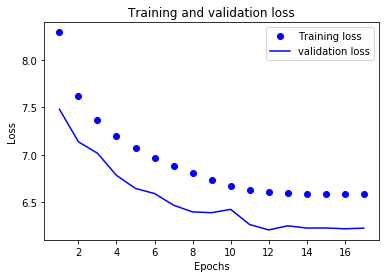

In [19]:
plotting.plot_loss(history)

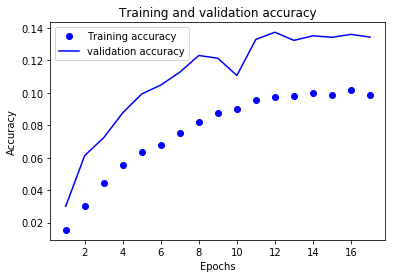

In [20]:
plt.clf()
plotting.plot_acc(
    history, 
    acc='class_acc',
    val_acc='val_class_acc'
)

In [ ]:
!tensorboard --logdir=Logs
# http://localhost:6006/

In [ ]:
from keras.utils import plot_model
plot_model(
    model, 
    show_shapes=True, 
    to_file='images/model.png'
)